### Import libraries

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Customize

In [5]:
#Provide customization parameters
my_data='0709 Stock Close Price.csv'
my_working_days=252
my_simulation=5000
my_period=1
my_output_file='0709 portfolio_simulations.csv'
my_optimal_file='0709 optimal_portfolio.csv'
my_saved_chart='0709 optimal_portfolio_pie_chart.png'

### Load data and calculate return

In [7]:
# Load the data
data = pd.read_csv(my_data, index_col=0, parse_dates=True)

# Calculate daily returns
returns = data.pct_change(periods=my_period).dropna()

# Annualize returns and covariance
mean_returns = returns.mean() * my_working_days
cov_matrix = returns.cov() * my_working_days

C:\Users\ahmed\AppData\Local\Temp\ipykernel_26272\3881268190.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(my_data, index_col=0, parse_dates=True)


### Create functions and define constraints

In [9]:
# Objective function (Portfolio variance)
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

# Constraints: Weights sum to 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: No short-selling (weights between 0 and 1)
bounds = tuple((0, 1) for _ in range(len(mean_returns)))

### Optimize

In [11]:
# Initial guess (equally distributed)
initial_weights = np.array([1/len(mean_returns)] * len(mean_returns))

# Optimization to minimize variance
optimized = minimize(portfolio_variance, initial_weights, args=(cov_matrix,),
                     method='SLSQP', bounds=bounds, constraints=constraints)

# Get optimized weights
opt_weights = optimized.x

### Run simulation 

In [13]:
# Calculate portfolio expected return and volatility
opt_return = np.dot(opt_weights, mean_returns)
opt_volatility = np.sqrt(portfolio_variance(opt_weights, cov_matrix))

# Run simulations to generate random portfolios
num_simulations = my_simulation
results = []

for _ in range(num_simulations):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    sim_return = np.dot(weights, mean_returns)
    sim_volatility = np.sqrt(portfolio_variance(weights, cov_matrix))
    results.append(np.concatenate((weights, [sim_return, sim_volatility])))

### Store and save results

In [15]:
# Create a DataFrame to store simulation results
columns = list(mean_returns.index) + ['Return', 'Volatility']
simulations_df = pd.DataFrame(results, columns=columns)

# Add the optimal portfolio as a separate row
opt_row = np.concatenate((opt_weights, [opt_return, opt_volatility]))
opt_df = pd.DataFrame([opt_row], columns=columns)
opt_df['Type'] = 'Optimal'
simulations_df['Type'] = 'Simulation'

# Combine dataframes
combined_df = pd.concat([simulations_df, opt_df], ignore_index=True)

# Save to CSV
combined_df.to_csv(my_output_file, index=False)

# Save optimal weights separately with corresponding return and volatility (column-wise)
optimal_summary_df = pd.DataFrame({
    'Asset': list(mean_returns.index) + ['Return', 'Volatility'],
    'Value': list(opt_weights) + [opt_return, opt_volatility]
})
optimal_summary_df.to_csv(my_optimal_file, index=False)

### Plot and print results

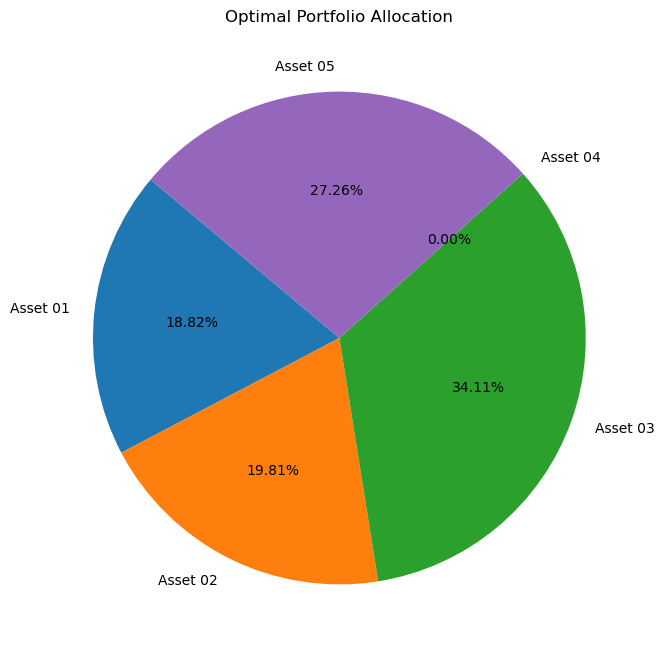

Optimized Portfolio Weights (%):
Asset 01: 18.8188%
Asset 02: 19.8074%
Asset 03: 34.1089%
Asset 04: 0.0000%
Asset 05: 27.2649%

Expected Annual Return: 23.4016%
Expected Annual Volatility: 26.6991%


In [17]:
# Plot pie chart for optimal asset allocation
plt.figure(figsize=(8, 8))
plt.pie(opt_weights, labels=mean_returns.index, autopct='%1.2f%%', startangle=140)
plt.title('Optimal Portfolio Allocation')
plt.savefig(my_saved_chart)
plt.show()

# Print optimal portfolio summary
print("Optimized Portfolio Weights (%):")
for asset, weight in zip(mean_returns.index, opt_weights):
    print(f"{asset}: {weight:.4%}")

print(f"\nExpected Annual Return: {opt_return:.4%}")
print(f"Expected Annual Volatility: {opt_volatility:.4%}")
